# CoRise Practice A/B Testing Course: Project 3

## Setup

Import libraries

In [1]:
# Libary basics
import numpy as np
import pandas as pd
import scipy.stats as stats # For pvalue
import math # For power calculation

Helper function to get the 95% confidence interval. Inputs:
* Mean treatment - average conversion rate of the treatment group
* Mean control - average conversion rate of the control group
* N treatment - number of samples in the treatment group
* N control - number of samples in the control group
* ci = The width of the confidence interval. 0.95 by default

You can read more about the math behind the confidence interval function [here](https://s3.amazonaws.com/assets.datacamp.com/production/course_6165/slides/chapter4.pdf).

In [2]:
def get_ci(mean_treatment, mean_control, n_treatment, n_control, ci = 0.95):
    sd = ((mean_treatment * (1 - mean_treatment)) / n_treatment + (mean_control * (1 - mean_control)) / n_control)**0.5
    lift = mean_treatment - mean_control
    val = stats.norm.isf((1 - ci) / 2)
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd
    return((lwr_bnd, upr_bnd))

Helper function to calcuate the results. It will compute and return the relative and absolute lift between variant and control, p-value, and lower and upper bound for the 95% confidence interval. A standard two-sided t-test with an assumption of equal variance is used to compute the p-value.

Inputs:
* DF = data frame with each row being a sample in the A/B test. It must have a column called "variant" that takes on the value "control" or "treatment
* Metric = the metric we want to evaluate. This must be 'new_active_listings','new_booked_listings', or 'cancellations'). If it is not one of these values an "invalid metric" error will be thrown.

In [3]:
def calculate_results(df,metric):
    # Check
    if metric not in ('new_active_listing','new_booked_listing','new_cancelled_listing','bookings_4w'):
        raise Exception("Invalid metric")

    # Values and relative difference
    mean_control = df.loc[df['variant'] == "control",metric].mean()
    mean_treatment = df.loc[df['variant'] == "treatment",metric].mean()

    abs_diff = mean_treatment-mean_control
    rel_diff = (mean_treatment-mean_control)/mean_control

    # P-Value -- two-sided ttest, assumes normal distribution
    data_group1 = list(df.query('variant == "control"')[metric])
    data_group2 = list(df.query('variant == "treatment"')[metric])

    results = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)
    pvaue = results.pvalue

    # 95% confidence intervals
    [ci_low, ci_high] = get_ci(mean_treatment,mean_control,len(data_group2),len(data_group1),.95)
    ci_low = ci_low/mean_control
    ci_high = ci_high/mean_control

    return(rel_diff,abs_diff,results.pvalue,ci_low,ci_high)

## Background

Welcome back **TinyTravelers**'s awesome product data scientist! You have developed strong relationships with PaM and the engineers on your team. You are a smooth, efficient, happy product-improving machine. Leadership has taken note and has given your team more resources to grow. You now have some new engineers and a new product manager, Maximus Impact ("Max" for short).

Like in past weeks, three A/B tests need to be designed and analyzed. Some back and forth communication with Max might also be needed.

## Task 1: Landing page change

The team has a hypothesis that a photo of a family instead of a baby will be more compelling to potential hosts. The thought of a baby staying alone in a house is terrifying. But a family with older kids and adults? Much less scary. That's the idea, anyways. So they want to try testing a photo for the landing page. See the design change below.

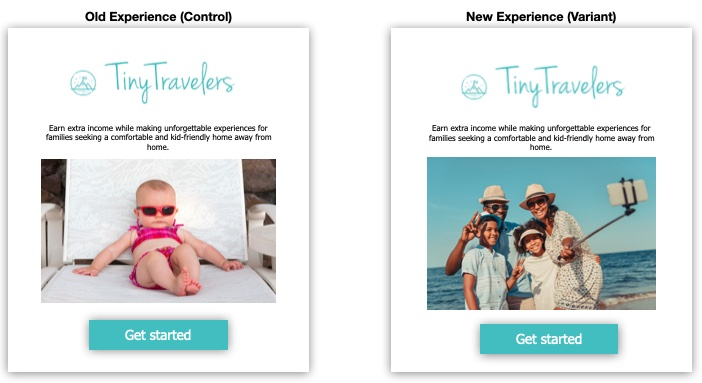

### Task 1.a. Test design by answering the following...

Like with prior weeks, we first want to determine how to implement the test, and what it is that we're testing for. With that in mind, you'll first need to decide when the test should be triggered: what should trigger the start of the test? Second, you'll need to determine what our hypothesis is. And remember, we're building on what we learned last week, so don't be afraid to look over your Week 1 and 2 projects if it will help you!

#### Task 1.a.i. When should the test be triggered?

| ------------------- _Answer_ ------------------- |

Ideally, users should be assigned to either the old experience (landing page with the image of the baby) or new experience (landing page with the image of the family) as close to the proposed change in the product experience as possible.

Here, that would mean users are assiged to see either the old experience or new experience immediately before the landing page loads.

| ---------------------------------------------- |

#### Task 1.a.ii. What is the hypothesis?

| ------------------- _Answer_ ------------------- |

You might phrase the hypothesis for this experiment like this:

_If we switch the image on the landing page from a baby to a family, New Booked Listings will increase, because potential hosts will feel more comfortable and therefore more likely to complete the onboarding process._

| ---------------------------------------------- |

#### Task 1.a.iii. How long should the test run and how will the launch/ no launch decision be made?

You can assume there will be 6000 new users per day reaching the landing page, and the cohort-to-book rate is 20%. Max hopes to detect a 2% change if it’s there, but he also doesn't want the test to run for more than three weeks as it's blocking some other work the team hopes to do.

You can use an online sample size calculator (e.g., Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html)). If you find that 2% is not feasible in 3 weeks, write how you would communicate the trade-off to Max.

| ------------------- _Answer_ ------------------- |

We would decide to launch if:

1. We see a relative increase in New Booked Listings that's practically signficant for the business (Max is suggesting 2%),
2. The result is statistically signficant, and
3. There isn't an overly negative impact on our guardrail metric, New Canceled Listings.

Given a 20% baseline conversion rate, a 2% minimum detectable relative effect size, a 50/50 split between control and treatment, a significance level of 5%, and a statistical power of 80%, we'll need 157,328 users in each variant, for a total of 314,656 users in the experiment.

With 6,000 new users arriving at the landing page each day, this suggests we'll need 52 or 53 days to reach our minimum required sample size. Since it will take another week for those new listings to get their first booking (or not), the experiment will need to run for **59 or 60 days**.

That's over eight weeks, which clearly doesn't meet Max's requirement for completing the test within three weeks.

When communicating these results to Max, I would ask him to prioritize what's most important to him:

1. The speed with which we can complete the test — for instance, within three weeks
2. Detecting a small effect size, if one exists
3. The likelihood that any statistically significant effect we find is real, and not a false positive

Let's assume it's really important to complete the test within three weeks. How large of an experiment can we run?

    6,000 users/day x 14 days = 84,000 users, or 42,000 users per variant

(Recall it will take the remaining seven days for these new listings to get their first booking or not.)

What are some options for running the experiment, assuming we'll have at most 42,000 users per variant?

- We could increase the minimum detectable effect size to 4%.
- We could increase the minimum detectable effect size to 3%, increase the significance level to 0.1, and decrease the statistical power to 70%. This option would somewhat increase the risks of both a false positive (detecting a statistically signficant effect when none really exists) and a false negative (failing to detect a statistically significant effect when one really does exist).

| ---------------------------------------------- |

### Task 1.b. Test analysis

**Warning**: This may give away the answer to part a, so you should complete the run time analysis first.

You bring these two data points to Max to align on the run-time. After discussing the run time vs. detectable change with Max, you aligned on running the test for four weeks with an alpha of 0.10. That means you will launch the test if the point estimate for new booked listings is positive with a p-value is less than 0.10.

Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided.

In [7]:
df_landing = pd.read_csv('content/dataset_landing_page.csv')

In [8]:
results_nal = calculate_results(df_landing, 'new_active_listing')
results_nbl = calculate_results(df_landing, 'new_booked_listing')
results_ncl = calculate_results(df_landing, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal,
        'new_booked_listing': results_nbl,
        'new_canceled_listing': results_ncl,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,-0.000238,0.021563,0.104587
abs_diff,-0.000094,0.001757,0.000253
pvalue,0.968525,0.191059,0.304473
ci_low,-0.012038,-0.010761,-0.095011
ci_high,0.011563,0.053887,0.304185


| ------------------- _Answer_ ------------------- |

New Booked Listings increased by a bit over 2%. However, the result was not statistically significant ($p=0.19$), even according to the more relaxed 90% significance level we agreed on.

New Active Listings did not seem to move at all. That's weird, given that our hypothesis expected this change to cause more prospective hosts to complete the onboarding flow.

In a potential cause for concern, our guardrail metric of New Canceled Listings increased by over 10%. This result wasn't statistically significant either, though ($p=0.3$)

Combined with our decision criteria outlined above, these results suggest we not launch the change.

| ---------------------------------------------- |

### Task 1.c. Stakeholder management

You share your recommendation in the stakeholder review meeting. Max speaks up:

"Looks to me like this change was actually solid, +2% on new booked listings! And the p-value is pretty close to 0.1, so I think we should ship."

How do you reply?

| ------------------- _Answer_ ------------------- |

It's important that we stick to the decision criteria we established up front about whether or not to launch.
We decided on these launch criteria for a reason, and changing our decision criteria after the fact to fit the data we happened to get degrades the value of running controlled experiments in the first place.

Further, there's reason to believe the result we got might be spurious.
If our hypothesis was correct, we'd expect to see an increase in both New Active Listings and New Booked Listings, but we didn't.
There was also a relatively large, though not statistically significant, increase in New Canceled Listings.
If we're willing to relax our standards for statistical significance on our target metric, we need to consider our guardrail metric, too. 

| ---------------------------------------------- |

## Task 2: Recommended price

Given the success of the default title in week 1 (remember chatGPT &rarr; 📈 &rarr; 🍾?), the team came up with the idea to try a default price for homes as well. At a high level, to come up with the recommended price, the team uses information that the host has entered about the home so far (e.g., location, how many guests can fit, etc.) and data from the existing home to come up with a price they think this house would be booked at. The model predicts a price while the page is loaded to ensure it's ready to display to the host when they see the page.

See the UI change below.

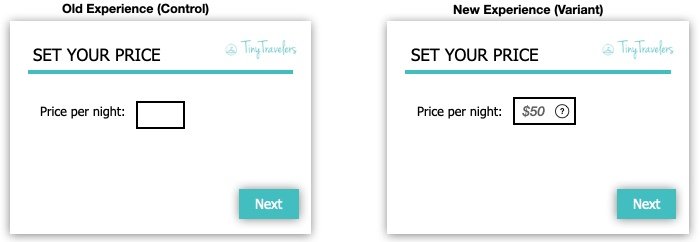

### Task 2.a. Test design by answering the following...

#### Task 2.a.i. When should the test be triggered?

| ------------------- _Answer_ ------------------- |

Ideally, users should be assigned to either the old experience (no recommended price) or new experience (Tiny Travelers recommends a price) as close to the proposed change in the product experience as possible.

Here, that would mean users are assiged to see either the old experience or new experience immediately before they encounter the "set your price" screen.

| ---------------------------------------------- |

#### Task 2.a.ii. What is the hypothesis?

| ------------------- _Answer_ ------------------- |

You might phrase the hypothesis for this experiment like this:

_If we automatically suggest a price as part of the onboarding flow for new hosts, New Booked Listings will increase, because we will remove a point of friction in the onboarding flow, and more users will complete the onboarding process and publish their listings._

Measuring the success or failure of this change using New Booked Listings as the target metric might be tricky.
Changing the price seems likely to affect whether or not a new listing receives a booking.
In this case, it might make sense to use something like the average booking revenue as a target metric, and New Booked Listings as a guardrail metric or informative metric.

| ---------------------------------------------- |

#### Task 2.a.iii. How long should the test run?

You can assume that about 4K new users arrive on the price page of the onboarding flow each day. And the cohort-to-book rate is estimated to be 40% because the cohorting happens later in the flow when only the higher intent people are still there. You can use an online sample size calculator (e.g., Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html)). Given that the default title had over a 10% relative increase  (week 1 project), Max is optimistic about this change. Still, he also recognizes this is a different kind of problem and later in the flow, so the impact might not be that big. So he'd like you to bring back some run-time vs. minimal detectable effect options.

Please share some run time vs MDE options. For an idea on what this could look like, refer to the [test design module](https://corise.com/course/practical-ab-testing/v2/module/test-design-basics#corise_clgpg1yqy000j3b712q0xi8wk), but instead of having one column be "users per a variant" it could be "needed run-time."

| ------------------- _Answer_ ------------------- |

Assuming 4,000 users enter the experiment each day, and given a 40% baseline conversion rate, a 50/50 split between control and treatment, a significance level of 5%, and a statistical power of 80%, here are some options for how long we'll need to run the experiment to detect different effect sizes:

| Minimum detectable relative impact | Required run-time |
| :---: | :---: |
| 11% | 8 days |
| 9% | 9 days |
| 5% | 12 days |
| 3% | 21 days |
| 2% | 36 days |

Keep in mind that after we've achieved the minimum number of users in our experiment, it will take a week for these listings to receive their first booking (or not), so we need to add another 7 days to the run-time. 

| ---------------------------------------------- |

### Task 2.b. Stakeholder management

**Warning** this may reveal the answer to the previous task so please complete the run-time first!

After discussing the options with Max, you collectively decide that 28 days is a good balance. We like to stick with run-times in week increments so sacrificing the 29th day seems OK. The team put a lot of work into developing the algorithm so Max wants to position them to detect a 2.1% change.

The test starts off and everyone is feeling cautiously optimistic and excited for more champagne 🍾.

About 48 hours pass when Max shows up at your desk.

"SOMETHING IS WRONG! The results look really bad. I know we said this was going to run for 28 days, but I feel like something is up. Can you take a look?"

You oblige. The results below are the test results after running for 2 days. Please analyze the results and share your reply to Max.

_Basic_: Please analyze the results and share your recommendation of how to proceed.

_Bonus_: Explore the data carefully, and try to determine what went wrong. Is there any additional data would you ask for to help investigate what happened?

In [9]:
df_price_1_early = pd.read_csv('content/df_price_1_early.csv')

In [10]:
results_nal = calculate_results(df_price_1_early, 'new_active_listing')
results_nbl = calculate_results(df_price_1_early, 'new_booked_listing')
results_ncl = calculate_results(df_price_1_early, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal,
        'new_booked_listing': results_nbl,
        'new_canceled_listing': results_ncl,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,-0.267622,-2.431669e-01,-0.159509
abs_diff,-0.208842,-1.146372e-02,-0.000061
pvalue,0.000000,3.327342e-08,0.754450
ci_low,-0.279558,-3.295474e-01,-1.159862
ci_high,-0.255686,-1.567864e-01,0.840844


In [11]:
df_price_1_early.head()

,Unnamed: 0,id_user,variant,continent,booked_previously,device,new_active_listing,new_booked_listing,new_cancelled_listing,hrs_in_exp
0,1,7181,control,europe,0,android,1,0,0,16.604418
1,2,11229,treatment,north_america,0,android,1,0,0,30.393129
2,3,50786,treatment,europe,0,android,0,0,0,0.644750
3,5,9519,treatment,north_america,0,android,0,0,0,39.788688
4,9,20281,control,north_america,0,android,1,0,0,27.964404


In [12]:
df_price_1_early['variant'].value_counts()

treatment    18582
control      18221
Name: variant, dtype: int64

In [17]:
df_price_1_early['id_user'].value_counts()

50059    2
14002    2
29638    2
8521     2
50994    2
        ..
42889    1
7526     1
14577    1
29575    1
4903     1
Name: id_user, Length: 31173, dtype: int64

In [18]:
df_price_1_early[df_price_1_early['id_user'] == 50059]

,Unnamed: 0,id_user,variant,continent,booked_previously,device,new_active_listing,new_booked_listing,new_cancelled_listing,hrs_in_exp
9069,27554,50059,control,africa,0,android,1,0,0,43.979005
22642,8273,50059,treatment,africa,1,web,1,0,0,4.803364


In [19]:
df_price_1_early[df_price_1_early['id_user'] == 14002]

,Unnamed: 0,id_user,variant,continent,booked_previously,device,new_active_listing,new_booked_listing,new_cancelled_listing,hrs_in_exp
9607,29152,14002,control,africa,0,android,1,0,0,7.628829
30426,31857,14002,control,north_america,1,ios,1,0,0,5.111582


| ------------------- |
_Write findings and recommendation here_
| ------------------- |

## Task 3: Recommended price v2

**Warning** this may reveal part of the solution to task 2, so please complete that first!

The bug you identified in the initial price recommendation test has been resolved. The team wants to try again. The design you did in task 2 holds, and you and Max decide that 28 days is still a good run-time.

### Task 3.a. Stakeholder management

The 48 hour mark passes and the results look OK. Everyone gives a collective sigh of relief. But then after 3 days, Max shows up to your desk.

These results are SO GOOD. We should ship right now. You ask for a tapering of excitement while you look into the results.

Below we provide the results after 3 days of the test running. Please analyze the results and make a recommendation on how to proceed.

In [21]:
df_price_2_early = pd.read_csv('content/dataset_price_v2_early.csv')

In [22]:
df_price_2_early['id_user'].value_counts()

94392     1
84273     1
101853    1
84663     1
14059     1
         ..
23421     1
8112      1
41147     1
107926    1
57149     1
Name: id_user, Length: 50636, dtype: int64

| ------------------- |
_Write findings and recommendation here_
| ------------------- |

### Task 3.b. Test analysis

**Warning** this may give away the answer to task 3.a. so we recommend doing that first.

Max agrees to wait the full 28 days, though he can't help but ask about how the test is doing a few more times :) The four weeks are up and it's time to look at the results. Please analyze the data provided below, and share a summary and recommendation on how to proceed.

In [6]:
df_price_2 = pd.read_csv('content/dataset_price_v2.csv')

# Code goes here

| ------------------- |
_Write findings and recommendation here_
| ------------------- |

### Task 3.c._(BONUS)_ Deep dive in analysis

Although everyone is happy the results ended positive in the end and the price recommender was able to launch, you want to understand _why_ the early results were so positive.

#### Task 3.c.i. What hypotheses do you have for why the early results were so positive?

Why do you think the early results were so much more positive than the end results? What analysis could you do to confirm or reject those hypthesis?

No code here- just thoughts.

| ------------------- |
_Write findings and recommendation here_
| ------------------- |

#### Task 3.c.ii. Show the results over time

Do the results vary by the day someone was cohorted? What does this tell you?

This section can take a while and require more advanced Python than you've needed to-date for this course, so we recommend coming back to it after the other tasks are complete.

In [ ]:
# Useful for visualization - you can use other libraries/ approaches though if you prefer!
import seaborn as sns

# Code goes here

| ------------------- |
_Write conclusion here_
| ------------------- |